In [34]:
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import time

from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from torch import nn
from torchvision import transforms

from DatasetMedical import DatasetCAMUS_r, DatasetCAMUS
from Unet2D import Unet2D

In [35]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, params_path, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc += acc * dataloader.batch_size
                running_loss += loss * dataloader.batch_size

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc,
                                                                                          torch.cuda.memory_allocated() / 1024 / 1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase == 'train' else valid_loss.append(epoch_loss)
        torch.save(model.state_dict(), params_path + f'{epoch}.pth')
    torch.save(model.state_dict(), params_path + 'final.pth')
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return train_loss, valid_loss

In [36]:
def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

def dice_metric(predb, yb):
    # Ventricle = 2, Background = 0
    segmented = 2 * predb.argmax(dim=1)

    # TP = 2 - 1 = 1, TN = 0 - 0 = 0, FP = 2 - 0 = 2, FN = 0 - 1 = -1
    conf = segmented - yb
    TP = (conf == 1).sum()
    TN = (conf == 0).sum()
    FP = (conf == 2).sum()
    FN = (conf == -1).sum()
    return 2 * TP / (2 * TP + FP + FN)

def batch_to_img(xb, idx):
    img = np.array(xb[idx, 0:3])
    return img.transpose((1, 2, 0))


def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [39]:
def main():
    # enable if you want to see some plotting
    visual_debug = True
    params_path = 'models/model_epoch_'

    # batch size
    bs = 12

    # epochs
    epochs_val = 3

    # learning rate
    learn_rate = 0.01
    
    # datasets, 0=background+LV, 1=b+LV+M+RV, 2=??
    datasets = ['CAMUS_resized', 'CAMUS', 'TEE']
    curr_dataset = datasets[1]

    # sets the matplotlib display backend (most likely not needed)
    # mp.use('TkAgg', force=True)
    
    # Preprocessing
    preprocess = transforms.Compose([
        #transforms.GaussianBlur(3, sigma=0.1)
        #transforms.Resize((224,224))
    ])

    # load the training data
    if curr_dataset == 'CAMUS_resized':
        base_path = Path('/work/datasets/medical_project/CAMUS_resized')
        data = DatasetCAMUS_r(base_path / 'train_gray', base_path / 'train_gt', transform=preprocess)
    elif curr_dataset == 'CAMUS':
        base_path = Path('/work/datasets/medical_project/CAMUS')
        data = DatasetCAMUS(base_path, transform=preprocess)
    elif curr_dataset == 'TEE':
        base_path = Path('/work/datasets/medical_project/TEE')
        data = DatasetTEE()
        
        
    print(len(data))

    # split the training dataset and initialize the data loaders
    train_dataset, valid_dataset, _ = torch.utils.data.random_split(
        data,
        (300, 100, 50),
        generator=torch.Generator().manual_seed(42)
    )

    train_data = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    valid_data = DataLoader(valid_dataset, batch_size=bs, shuffle=False)

    if visual_debug:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(data.open_as_array(100))
        ax[1].imshow(data.open_mask(100))
        plt.show()

    

patient0004_4CH_ED.mhd loaded. Shape: (641, 908, 1)
patient0004_4CH_ED_gt.mhd loaded. Shape: (641, 908, 1)
patient0134_4CH_ED.mhd loaded. Shape: (482, 843, 1)
patient0134_4CH_ED_gt.mhd loaded. Shape: (482, 843, 1)
patient0008_4CH_ED.mhd loaded. Shape: (787, 1297, 1)
patient0008_4CH_ED_gt.mhd loaded. Shape: (787, 1297, 1)
patient0017_4CH_ED.mhd loaded. Shape: (630, 1038, 1)
patient0017_4CH_ED_gt.mhd loaded. Shape: (630, 1038, 1)
patient0411_4CH_ED.mhd loaded. Shape: (512, 843, 1)
patient0411_4CH_ED_gt.mhd loaded. Shape: (512, 843, 1)
patient0399_4CH_ED.mhd loaded. Shape: (624, 973, 1)
patient0399_4CH_ED_gt.mhd loaded. Shape: (624, 973, 1)
patient0011_4CH_ED.mhd loaded. Shape: (512, 843, 1)
patient0011_4CH_ED_gt.mhd loaded. Shape: (512, 843, 1)
patient0067_4CH_ED.mhd loaded. Shape: (551, 908, 1)
patient0067_4CH_ED_gt.mhd loaded. Shape: (551, 908, 1)
patient0151_4CH_ED.mhd loaded. Shape: (708, 1167, 1)
patient0151_4CH_ED_gt.mhd loaded. Shape: (708, 1167, 1)
patient0108_4CH_ED.mhd loaded. 

450


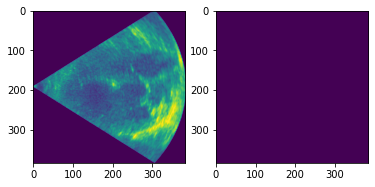

In [40]:
if __name__ == "__main__":
    main()